In [53]:
import pandas as pd
import numpy as np
audata = pd.read_csv("RESULT_new3/fu/fu2105_fu2109_final.csv", index_col=[0], parse_dates=[0])
audata

,trading_date,id_A,ask_A,ask_vol_A,bid_A,bid_vol_A,last_A,id_B,ask_B,ask_vol_B,bid_B,bid_vol_B,last_B,spd_ask,spd_bid,spd_last
date_time,,,,,,,,,,,,,,,,
2020-08-31 21:01:53.000,2020-09-01,fu2105,2119.0,8.0,2118.0,3.0,2119.0,fu2109,2363.0,3.0,2177.0,1.0,2229.0,-59.0,-244.0,-110.0
2020-08-31 21:05:50.500,2020-09-01,fu2105,2114.0,2.0,2113.0,4.0,2114.0,fu2109,2274.0,1.0,2216.0,3.0,2289.0,-103.0,-160.0,-175.0
2020-08-31 21:10:59.000,2020-09-01,fu2105,2113.0,10.0,2112.0,1.0,2113.0,fu2109,2235.0,1.0,2218.0,1.0,2225.0,-106.0,-122.0,-112.0
2020-08-31 21:17:58.500,2020-09-01,fu2105,2114.0,4.0,2113.0,6.0,2114.0,fu2109,2225.0,2.0,2208.0,2.0,2219.0,-95.0,-111.0,-105.0
2020-08-31 21:23:24.000,2020-09-01,fu2105,2115.0,6.0,2114.0,1.0,2114.0,fu2109,2234.0,12.0,2225.0,1.0,2229.0,-111.0,-119.0,-115.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30 14:51:21.500,2021-04-30,fu2105,0.0,0.0,2350.0,15.0,2350.0,fu2109,2534.0,501.0,2533.0,14.0,2533.0,-183.0,-2534.0,-183.0
2021-04-30 14:53:44.500,2021-04-30,fu2105,0.0,0.0,2350.0,15.0,2350.0,fu2109,2538.0,138.0,2537.0,246.0,2537.0,-187.0,-2538.0,-187.0
2021-04-30 14:56:22.500,2021-04-30,fu2105,0.0,0.0,2350.0,15.0,2350.0,fu2109,2534.0,356.0,2533.0,434.0,2534.0,-183.0,-2534.0,-184.0


In [54]:
audata.id_A.unique()

array(['fu2105'], dtype=object)

In [55]:
data_all = audata[['trading_date','last_A', 'last_B']]

pd_date_list = pd.DataFrame()
pd_date_list['time_stamp'] = pd.to_datetime(data_all['trading_date'])
# normalize, count values, convert to dataframe
pd_date_list = pd_date_list['time_stamp'].dt.normalize().value_counts().to_frame().reset_index()
# rename columns
pd_date_list.columns = ['time_stamp', 'count']
pd_date_list.sort_values(by='time_stamp',inplace=True)
pd_date_list = pd_date_list.reset_index()
pd_date_list.drop(columns='index',inplace=True)
pd_date_list


,time_stamp,count
0,2020-09-01,42
1,2020-09-02,41
2,2020-09-03,48
3,2020-09-04,47
4,2020-09-07,50
...,...,...
155,2021-04-26,137
156,2021-04-27,137
157,2021-04-28,137
158,2021-04-29,137


In [8]:
def find_best_k(MSpread,Spread):
    cost_rate = 0.5 / 10000
    best_K = None
    best_K_res = None


    K_options = np.arange(0.01, 2.5, 0.01)
    k_res = -1
    for K in K_options:
        
        holding = False
        direction = None  # "a-b", "b-a"
        enter_record = []
        out_record = []

        pure_pnl = []
        trading_cost = []
        pnl = []
        
        up_threshold =  K * np.std(MSpread)
        down_threshold = - up_threshold
        
        for i, v in enumerate(MSpread):
            if not holding:
                # 判断进场条件
                if v > up_threshold:
                    holding = True
                    direction = 'b-a'
                    enter_record.append((i, v))
                elif v < down_threshold:
                    holding = True
                    direction = 'a-b'
                    enter_record.append((i, v))

            elif holding:
                # 判断离场条件
                if direction == 'a-b' and v > 0.1:
                    holding = False
                    out_record.append((i, v))

                    out_price = Spread[i]
                    last_enter_price = Spread[enter_record[-1][0]]
                    single_ret = (out_price - last_enter_price)
                    single_cost = cost_rate * (data.last_A[i] + data.last_B[i] + 
                                                data.last_A[enter_record[-1][0]] + data.last_B[enter_record[-1][0]])

                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)


                elif direction =='b-a' and v < -0.1:
                    holding = False
                    out_record.append((i, v))
                    out_price = Spread[i]
                    last_enter_price = Spread[enter_record[-1][0]]
                    single_ret = (last_enter_price - out_price)
                    single_cost = cost_rate * (data.last_A[i] + data.last_B[i] + 
                                                data.last_A[enter_record[-1][0]] + data.last_B[enter_record[-1][0]])            

                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)

                    
        if holding:
            # print('还有持仓，强平')
            if direction == 'a-b':
                ret = (Spread[-1] - Spread[enter_record[-1][0]])
            else:
                ret = (Spread[enter_record[-1][0]] - Spread[-1])

            single_cost = cost_rate * (data.last_A[-1] + data.last_B[-1] + 
                                                    data.last_A[enter_record[-1][0]] + data.last_B[enter_record[-1][0]])
            pure_pnl.append(ret)
            trading_cost.append(single_cost)
            pnl.append(ret - single_cost)
        if len(pnl) > 0:
            final_pnl = np.array(pnl).cumsum()[-1]
            if best_K_res is None:
                best_K_res = final_pnl
                K_res = K
                
            elif final_pnl > best_K_res:
                best_K_res = final_pnl
                k_res = K
    print(k_res,best_K_res)
    return k_res

In [69]:
import statsmodels.api as sm
holding = False
direction = None  # "a-b", "b-a"
enter_record = []
out_record = []

pure_pnl = []
trading_cost = []
pnl = []
cost_rate = 0.5 / 10000
delta_days = 1
K = 0
beta = 0
data_all['trading_date']  =  pd.to_datetime(data_all['trading_date']) #处理交易日时刻
data_beta = pd.DataFrame()
#取最近5天数据
for date_index in range(57,len(pd_date_list) - delta_days):

    start_time = pd_date_list['time_stamp'].iloc[date_index]
    end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
    data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]

    start_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
    end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]  + pd.Timedelta("2 day")
    test_data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]

    model = sm.OLS(data.last_A, data.last_B).fit()
    print(model.params)

    beta = model.params['last_B']

    eps = data.last_A - data.last_B * beta
    eps2 = test_data.last_A - test_data.last_B * beta

    Spread = data.last_A - data.last_B
    Spread2 = test_data.last_A - test_data.last_B

    df = pd.concat([eps2, Spread2], axis=1)
    data_beta = data_beta.append(df)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
last_B    0.961311
dtype: float64
last_B    0.965837
dtype: float64
last_B    0.967931
dtype: float64
last_B    0.97094
dtype: float64
last_B    0.972809
dtype: float64
last_B    0.971119
dtype: float64
last_B    0.967455
dtype: float64
last_B    0.966746
dtype: float64
last_B    0.966079
dtype: float64
last_B    0.96819
dtype: float64
last_B    0.970929
dtype: float64
last_B    0.969343
dtype: float64
last_B    0.970041
dtype: float64
last_B    0.975161
dtype: float64
last_B    0.974571
dtype: float64
last_B    0.97436
dtype: float64
last_B    0.974074
dtype: float64
last_B    0.966547
dtype: float64
last_B    0.965366
dtype: float

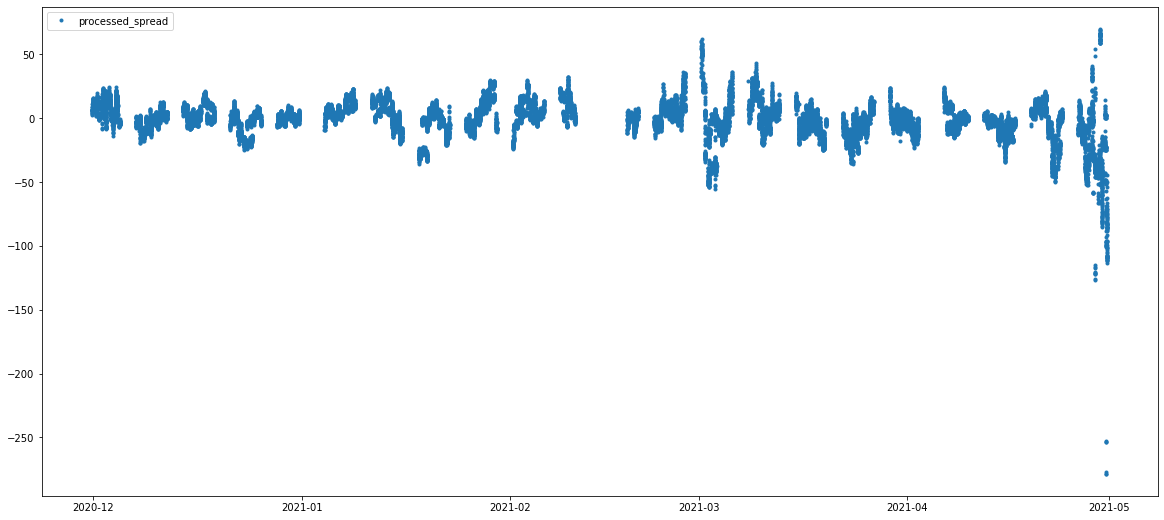

In [74]:
plt.figure(figsize=(20,9))
plt.plot(data_beta[0],'.', label='processed_spread')
# plt.plot(data_beta[1],'.', label='original_spread')
plt.legend()

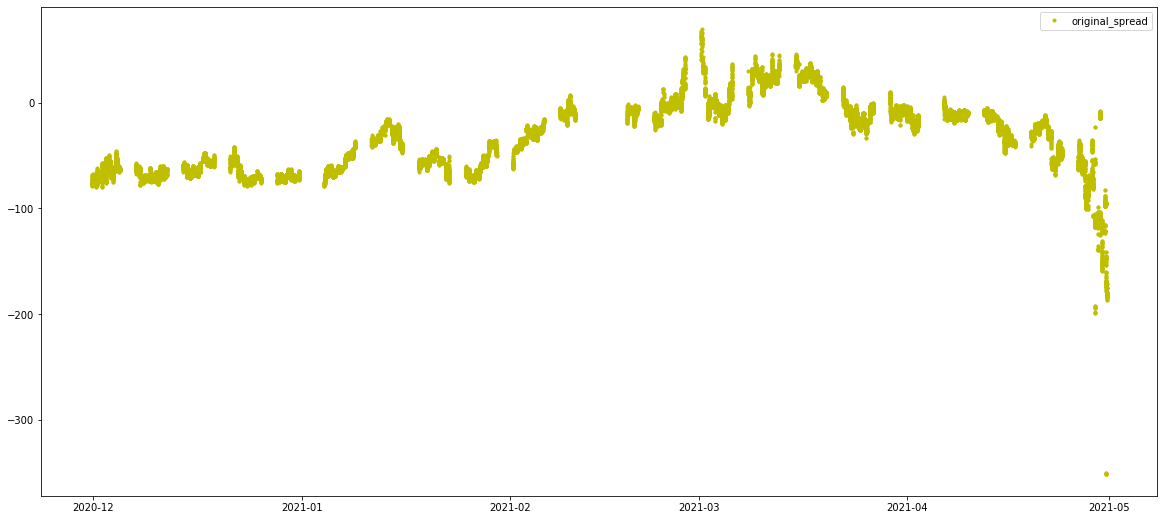

In [75]:
plt.figure(figsize=(20,9))
# plt.plot(data_beta[0],'.', label='processed_spread')
plt.plot(data_beta[1],'.', color = 'y',label='original_spread')
plt.legend()

In [84]:
import statsmodels.api as sm
holding = False
direction = None  # "a-b", "b-a"
enter_record = []
out_record = []

pure_pnl = []
trading_cost = []
pnl = []
cost_rate = 0.5 / 10000
delta_days = 1
K = 0
beta = 0
data_all['trading_date']  =  pd.to_datetime(data_all['trading_date']) #处理交易日时刻
#取最近5天数据
for date_index in range(57,len(pd_date_list) - delta_days):

    start_time = pd_date_list['time_stamp'].iloc[date_index]
    end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
    data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]

    start_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
    end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]  + pd.Timedelta("2 day")
    test_data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]

    model = sm.OLS(data.last_A, data.last_B).fit()
    print(model.params)

    beta = model.params['last_B']

    eps = data.last_A - data.last_B * beta
    eps2 = test_data.last_A - test_data.last_B * beta

    Spread = data.last_A - data.last_B
    Spread2 = test_data.last_A - test_data.last_B

    print('test_day:',start_time)
    best_k = find_best_k(eps,Spread)

    #进入交易
    if K == 0:
        K = best_k

    K = best_k * 0.4 + K * 0.6
    # K = best_k

    up_threshold =  K * np.std(eps)
    down_threshold = - up_threshold

    print('beta:',beta)
    print('阈值：',up_threshold)

    for i, v in enumerate(eps2.values):
        if not holding:
            # 判断进场条件
            if v > up_threshold:
                holding = True
                direction = 'b-a'
                print('b-a进场', Spread2[i], v)
                enter_record.append((Spread2[i], v))
            elif v < down_threshold:
                holding = True
                direction = 'a-b'
                print('a-b进场', Spread2[i], v)
                enter_record.append((Spread2[i], v))
                
        elif holding:
            # 判断离场条件
            if direction == 'a-b' and v > 0.001:
                holding = False
                print('a-b出场', Spread2[i], v)
                out_record.append((Spread2[i], v))
                
                out_price = Spread2[i]
                last_enter_price = enter_record[-1][0]
                single_ret = (out_price - last_enter_price)
                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2

                pure_pnl.append(single_ret)
                trading_cost.append(single_cost)
                pnl.append(single_ret - single_cost)
                
                
            elif direction =='b-a' and v < -0.001:
                holding = False
                print('b-a出场', Spread2[i], v)
                out_record.append((Spread2[i], v))
                out_price = Spread2[i]
                last_enter_price = enter_record[-1][0]
                single_ret = (last_enter_price - out_price)
                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2           
                
                pure_pnl.append(single_ret)
                trading_cost.append(single_cost)
                pnl.append(single_ret - single_cost)

            # 判断止损条件
            # if direction == 'a-b' and v > 0.001:
            #     holding = False
            #     print('a-b出场', Spread2[i], v)
            #     out_record.append((Spread2[i], v))
                
            #     out_price = Spread2[i]
            #     last_enter_price = enter_record[-1][0]
            #     single_ret = (out_price - last_enter_price)
            #     single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2

            #     pure_pnl.append(single_ret)
            #     trading_cost.append(single_cost)
            #     pnl.append(single_ret - single_cost)
                
                
            # elif direction =='b-a' and v < -0.001:
            #     holding = False
            #     print('b-a出场', Spread2[i], v)
            #     out_record.append((Spread2[i], v))
            #     out_price = Spread2[i]
            #     last_enter_price = enter_record[-1][0]
            #     single_ret = (last_enter_price - out_price)
            #     single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2           
                
            #     pure_pnl.append(single_ret)
            #     trading_cost.append(single_cost)
            #     pnl.append(single_ret - single_cost)
            
if holding:
    print('还有持仓，强平')
    if direction == 'a-b':
        ret = (Spread2[-1] - enter_record[-1][0])
    else:
        ret = (enter_record[-1][0] - Spread2[-1])
    
    single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2  
    pure_pnl.append(ret)
    trading_cost.append(single_cost)
    pnl.append(ret - single_cost)

72.0 -0.8230718311565397
b-a进场 -69.0 2.242771765669204
last_B    0.970207
dtype: float64
test_day: 2021-01-28 00:00:00
1.47 14.7157
beta: 0.9702073769857539
阈值： 4.223893273744838
last_B    0.974991
dtype: float64
test_day: 2021-01-29 00:00:00
0.67 16.43255
beta: 0.9749907689388474
阈值： 2.925237791154381
last_B    0.982236
dtype: float64
test_day: 2021-02-01 00:00:00
0.6 29.249400000000005
beta: 0.9822361741333285
阈值： 1.6332190969453855
b-a出场 -40.0 -0.937346919189622
a-b进场 -42.0 -2.8485277898562344
a-b出场 -37.0 2.648859334410645
b-a进场 -36.0 3.648859334410645
b-a出场 -40.0 -0.13797475518913416
b-a进场 -38.0 1.8442614189439155
b-a出场 -43.0 -2.7649344119890884
a-b进场 -42.0 -1.8715173671889715
a-b出场 -40.0 0.2350655880109116
a-b进场 -43.0 -2.8004620637225344
last_B    0.977314
dtype: float64
test_day: 2021-02-02 00:00:00
1.75 29.1297
beta: 0.9773142718450587
阈值： 8.52704886938442
a-b出场 -42.0 8.407687960279418
b-a进场 -41.0 9.45305941658944
last_B    0.98217
dtype: float64
test_day: 2021-02-03 00:00:00
1.

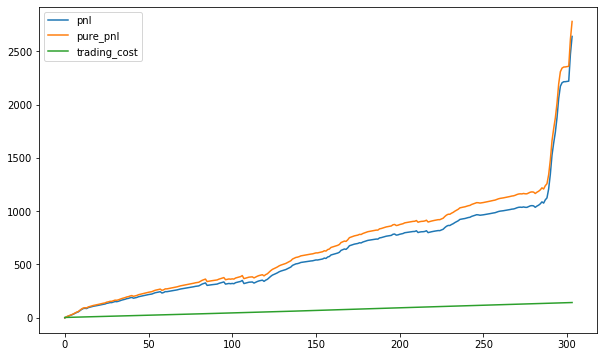

2640.3779

In [85]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(np.array(pnl).cumsum(), label='pnl')
plt.plot(np.array(pure_pnl).cumsum(), label='pure_pnl')
plt.plot(np.array(trading_cost).cumsum(), label='trading_cost')
plt.legend()
plt.show()
np.array(pnl).sum()

In [554]:
start_time = pd_date_list['time_stamp'].iloc[34]
end_time = pd_date_list['time_stamp'].iloc[34] + pd.Timedelta("1 day")
data = data_all[(data_all.index >= start_time) & (data_all.index <= end_time)]

model = sm.OLS(data.last_A, data.last_B).fit()
print(data)
print(model.params)

beta = model.params['last_B']

eps = data.last_A - data.last_B * beta

Spread = data.last_A - data.last_B
best_k = find_best_k(eps,Spread)

#进入交易

K_use = best_k * 0.4 + K * 0.6
up_threshold =  K_use * np.std(eps)
down_threshold = - up_threshold
print(K_use)

                      last_A   last_B
date_time                            
2021-05-17 09:00:00  15250.0  15125.0
2021-05-17 09:01:00  15265.0  15140.0
2021-05-17 09:02:00  15265.0  15140.0
2021-05-17 09:03:00  15250.0  15120.0
2021-05-17 09:04:00  15255.0  15120.0
...                      ...      ...
2021-05-17 23:56:00  15405.0  15255.0
2021-05-17 23:57:00  15405.0  15245.0
2021-05-17 23:58:00  15405.0  15250.0
2021-05-17 23:59:00  15400.0  15250.0
2021-05-18 00:00:00  15400.0  15245.0

[410 rows x 2 columns]
last_B    1.009315
dtype: float64
0.12 264.561
0.16589204636031263


In [544]:
up_threshold

2.58676479680558

#### 相关性检验 

In [56]:
import numpy as np
from scipy import stats
correlation, pvalue = stats.spearmanr(data.last_A, data.last_B)
print("coef:", round(correlation, 3), ",p-value:", pvalue)
print("------")
correlation, pvalue = stats.spearmanr(np.diff(data.last_A) / data.last_A.shift()[1:], np.diff(data.last_B)/data.last_B.shift()[1:])
print("coef:", round(correlation, 3), ",p-value:", pvalue)


coef: 0.995 ,p-value: 1.996658819248616e-136
------
coef: 0.961 ,p-value: 4.169100367752402e-77


#### ADF检验 

In [57]:
import statsmodels.tsa.stattools as ts
adf1 = ts.adfuller(np.diff(data.last_A))
adf2 = ts.adfuller(np.diff(data.last_B))
print(adf1)
print(adf2)

(-11.668954765240846, 1.854702370969719e-21, 0, 136, {'1%': -3.4793722137854926, '5%': -2.8830370378332995, '10%': -2.578233635380623}, 709.1400958394421)
(-12.284882736148974, 8.067912834144584e-23, 0, 136, {'1%': -3.4793722137854926, '5%': -2.8830370378332995, '10%': -2.578233635380623}, 682.4262795733309)


In [58]:
adf3 = ts.adfuller(data.last_A)
adf4 = ts.adfuller(data.last_B)
print(adf3)
print(adf4)

(-0.5695949884774519, 0.8777053814263264, 0, 137, {'1%': -3.479007355368944, '5%': -2.8828782366015093, '10%': -2.5781488587564603}, 708.6603509772357)
(-0.7607424394608081, 0.8303826478161221, 0, 137, {'1%': -3.479007355368944, '5%': -2.8828782366015093, '10%': -2.5781488587564603}, 682.3153333570367)


#### OLS回归

In [59]:
import statsmodels.api as sm
model = sm.OLS(data.last_A, data.last_B).fit()
print(model.params)
beta = model.params['last_B']

last_B    0.998967
dtype: float64


#### 残差单位根检验

In [60]:
eps = data.last_A - data.last_B * beta
eps2 = test_data.last_A - test_data.last_B * beta
print(ts.adfuller(eps))
print(ts.adfuller(eps2))

(-1.9043372680765465, 0.33002348202128157, 2, 135, {'1%': -3.479742586699182, '5%': -2.88319822181578, '10%': -2.578319684499314}, 348.38564093158743)
(-1.451900813459132, 0.5571571296511864, 2, 87, {'1%': -3.5078527246648834, '5%': -2.895382030636155, '10%': -2.584823877658872}, 227.34938422584273)


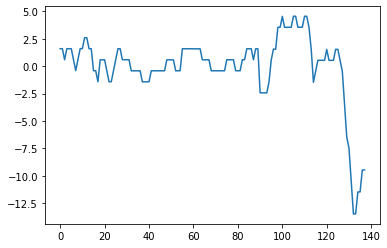

In [61]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot([i for i in range(len(eps))], eps.values)
plt.show()

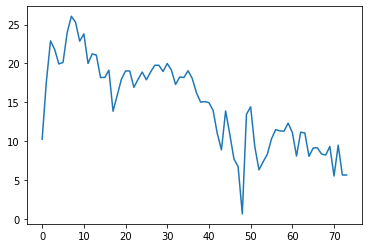

In [175]:
plt.figure()
plt.plot([i for i in range(len(eps2))], eps2.values)
plt.show()

#### 序列去中心化 

In [177]:
Spread = data.last_A - data.last_B

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


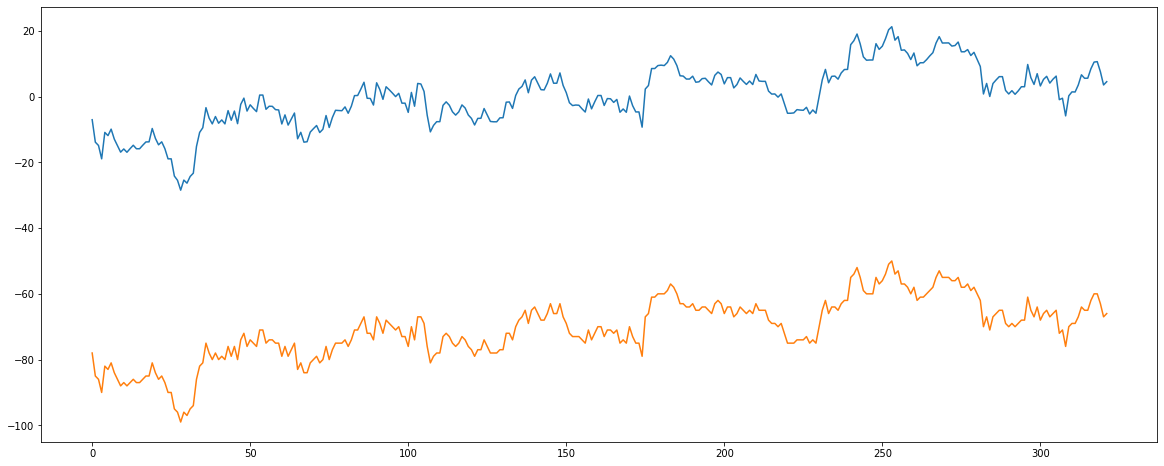

In [178]:
plt.figure(figsize=(20,8))
plt.plot([i for i in range(len(eps))], eps.values)
plt.plot([i for i in range(len(Spread))], Spread)
plt.show()

In [181]:
MSpread = eps 
MSpread

date_time
2020-11-27 20:55:00    -7.030853
2020-11-27 21:00:00   -13.864493
2020-11-27 21:05:00   -14.864493
2020-11-27 21:10:00   -18.931037
2020-11-27 21:15:00   -10.897765
                         ...    
2020-12-03 22:40:00    10.503340
2020-12-03 22:45:00    10.636428
2020-12-03 22:50:00     7.569884
2020-12-03 22:55:00     3.536612
2020-12-03 23:00:00     4.536612
Length: 322, dtype: float64

#### 样本内回测


In [200]:
holding = False
direction = None  # "a-b", "b-a"
enter_record = []
out_record = []

pure_pnl = []
trading_cost = []
pnl = []
cost_rate = 0.5 / 10000


K = 0.43

up_threshold =  K * np.std(MSpread)
down_threshold = - up_threshold
print(up_threshold, down_threshold)

for i, v in enumerate(MSpread.values):
    if not holding:
        # 判断进场条件
        if v > up_threshold:
            holding = True
            direction = 'b-a'
            print('b-a进场', i, v)
            enter_record.append((i, v))
        elif v < down_threshold:
            holding = True
            direction = 'a-b'
            print('a-b进场', i, v)
            enter_record.append((i, v))
            
    elif holding:
        # 判断离场条件
        if direction == 'a-b' and v > 0.001:
            holding = False
            print('a-b出场', i, v)
            out_record.append((i, v))
            
            out_price = Spread[i]
            last_enter_price = Spread[enter_record[-1][0]]
            single_ret = (out_price - last_enter_price)
            single_cost = cost_rate * (data.last_A[i] + data.last_B[i] + 
                                         data.last_A[enter_record[-1][0]] + data.last_B[enter_record[-1][0]])

            pure_pnl.append(single_ret)
            trading_cost.append(single_cost)
            pnl.append(single_ret - single_cost)
            
            
        elif direction =='b-a' and v < -0.001:
            holding = False
            print('b-a出场', i, v)
            out_record.append((i, v))
            out_price = Spread[i]
            last_enter_price = Spread[enter_record[-1][0]]
            single_ret = (last_enter_price - out_price)
            single_cost = cost_rate * (data.last_A[i] + data.last_B[i] + 
                                         data.last_A[enter_record[-1][0]] + data.last_B[enter_record[-1][0]])            
            
            pure_pnl.append(single_ret)
            trading_cost.append(single_cost)
            pnl.append(single_ret - single_cost)
            
if holding:
    print('还有持仓，强平')
    if direction == 'a-b':
        ret = (Spread[-1] - Spread[enter_record[-1][0]])
    else:
        ret = (Spread[enter_record[-1][0]] - Spread[-1])
    single_cost = cost_rate * (data.last_A[-1] + data.last_B[-1] + 
                                            data.last_A[enter_record[-1][0]] + data.last_B[enter_record[-1][0]])
    pure_pnl.append(ret)
    trading_cost.append(single_cost)
    pnl.append(ret - single_cost)
    

3.9399074884631604 -3.9399074884631604
a-b进场 0 -7.030852605605105
a-b出场 53 0.46822719323017736
a-b进场 58 -3.964308632427219
a-b出场 83 0.3018672602852348
b-a进场 86 4.368411233463121
b-a出场 87 -0.4985008201806522
b-a进场 90 4.202051300518178
b-a出场 92 -0.8312206860709921
a-b进场 100 -4.797948699481822
a-b出场 101 1.2685952736960644
b-a进场 103 4.002419380983611
b-a出场 106 -5.663020350796842
a-b进场 107 -10.729564323974728
a-b出场 134 0.33697964920315826
b-a进场 137 5.070803756490932
b-a出场 151 -1.8626522703309547
a-b进场 156 -4.696292337385785
a-b出场 160 0.33697964920315826
a-b进场 167 -4.762836310563898
a-b出场 170 0.1706197162582157
a-b进场 172 -4.663020350796842
a-b出场 175 2.305548064943423
b-a进场 177 8.538451971066706
b-a出场 217 -0.16210014963212416
a-b进场 220 -5.062284189865068
a-b出场 231 5.104075743080102
b-a进场 232 8.270435676025272
b-a出场 306 -0.9310366458380486
a-b进场 308 -5.862652270330955
a-b出场 309 0.23716368943610178
b-a进场 313 6.636427528504555
还有持仓，强平


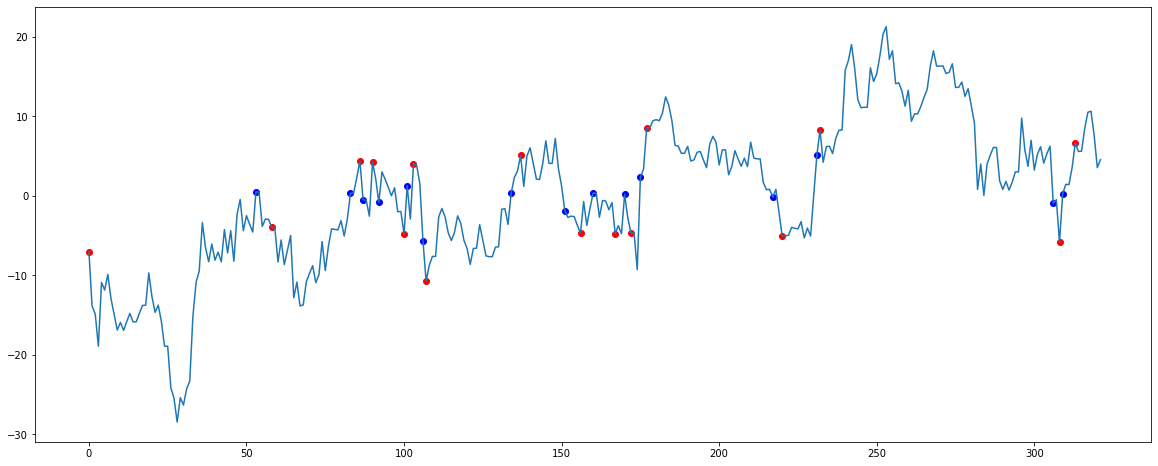

In [202]:
plt.figure(figsize=(20,8))
plt.plot([i for i in range(len(MSpread))], MSpread)
plt.scatter(np.array(enter_record)[:, 0], np.array(enter_record)[:, 1], color = 'r')
plt.scatter(np.array(out_record)[:, 0], np.array(out_record)[:, 1], color = 'b')

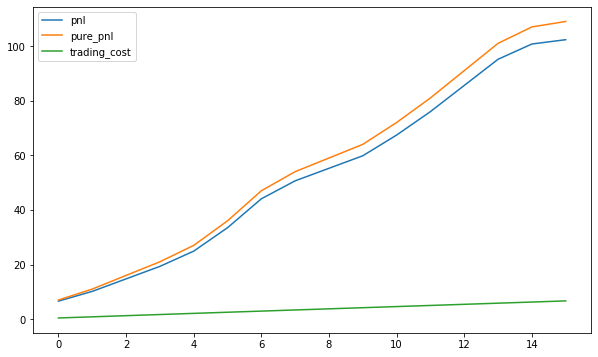

In [203]:
plt.figure(figsize=(10,6))
plt.plot(np.array(pnl).cumsum(), label='pnl')
plt.plot(np.array(pure_pnl).cumsum(), label='pure_pnl')
plt.plot(np.array(trading_cost).cumsum(), label='trading_cost')
plt.legend()

#### 最佳参数 

In [197]:
cost_rate = 0.5 / 10000
best_K = None
best_K_res = None


K_options = np.arange(0.01, 2.5, 0.01)

for K in K_options:
    
    holding = False
    direction = None  # "a-b", "b-a"
    enter_record = []
    out_record = []

    pure_pnl = []
    trading_cost = []
    pnl = []
    
    up_threshold =  K * np.std(MSpread)
    down_threshold = - up_threshold
    
    for i, v in enumerate(MSpread):
        if not holding:
            # 判断进场条件
            if v > up_threshold:
                holding = True
                direction = 'b-a'
                enter_record.append((i, v))
            elif v < down_threshold:
                holding = True
                direction = 'a-b'
                enter_record.append((i, v))

        elif holding:
            # 判断离场条件
            if direction == 'a-b' and v > 0.1:
                holding = False
                out_record.append((i, v))

                out_price = Spread[i]
                last_enter_price = Spread[enter_record[-1][0]]
                single_ret = (out_price - last_enter_price)
                single_cost = cost_rate * (data.last_A[i] + data.last_B[i] + 
                                             data.last_A[enter_record[-1][0]] + data.last_B[enter_record[-1][0]])

                pure_pnl.append(single_ret)
                trading_cost.append(single_cost)
                pnl.append(single_ret - single_cost)


            elif direction =='b-a' and v < -0.1:
                holding = False
                out_record.append((i, v))
                out_price = Spread[i]
                last_enter_price = Spread[enter_record[-1][0]]
                single_ret = (last_enter_price - out_price)
                single_cost = cost_rate * (data.last_A[i] + data.last_B[i] + 
                                             data.last_A[enter_record[-1][0]] + data.last_B[enter_record[-1][0]])            

                pure_pnl.append(single_ret)
                trading_cost.append(single_cost)
                pnl.append(single_ret - single_cost)

                
    if holding:
        # print('还有持仓，强平')
        if direction == 'a-b':
            ret = (Spread[-1] - Spread[enter_record[-1][0]])
        else:
            ret = (Spread[enter_record[-1][0]] - Spread[-1])
        single_cost = cost_rate * (data.last_A[-1] + data.last_B[-1] + 
                                             data.last_A[enter_record[-1][0]] + data.last_B[enter_record[-1][0]])
        pure_pnl.append(ret)
        trading_cost.append(single_cost)
        pnl.append(ret - single_cost)
        
    final_pnl = np.array(pnl).cumsum()[-1]
    print(K,final_pnl)
    if best_K_res is None:
        best_K_res = final_pnl
        K_res = K
        
    elif final_pnl > best_K_res:
        best_K_res = final_pnl
        k_res = K

0.01 90.8171
0.02 90.8171
0.03 90.8171
0.04 92.23315000000001
0.05 92.23315000000001
0.060000000000000005 94.65565
0.06999999999999999 96.65575
0.08 96.65575
0.09 91.06855
0.09999999999999999 91.06855
0.11 91.06855
0.12 91.06855
0.13 91.06855
0.14 91.06855
0.15000000000000002 91.06855
0.16 93.06815
0.17 93.06815
0.18000000000000002 93.06815
0.19 93.06815
0.2 93.06815
0.21000000000000002 93.06815
0.22 96.0677
0.23 99.06774999999999
0.24000000000000002 96.48849999999999
0.25 98.4881
0.26 99.48865
0.27 99.48865
0.28 97.48935
0.29000000000000004 97.48935
0.3 100.4897
0.31 102.48949999999999
0.32 95.90895
0.33 91.3287
0.34 93.3287
0.35000000000000003 93.3287
0.36000000000000004 93.3287
0.37 98.32795000000002
0.38 98.32795000000002
0.39 101.32750000000001
0.4 101.32750000000001
0.41000000000000003 102.32745
0.42000000000000004 102.32745
0.43 102.32775000000001
0.44 88.74525
0.45 92.74625
0.46 88.16720000000001
0.47000000000000003 88.16720000000001
0.48000000000000004 83.58965
0.49 83.58965
0

In [199]:
print(k_res)
best_K_res

0.31


102.48949999999999

In [187]:
print("收益率：")
best_K_res / (2000)

收益率：


0.062239275000000004